<a href="https://colab.research.google.com/github/slgemanay/-_HW2/blob/main/HW2_%D0%9D%D0%98%D0%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Necessary imports**

In [15]:
!apt-get update

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz

!tar xf spark-2.3.1-bin-hadoop2.7.tgz

!pip install -q findspark



import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"



!ls



import findspark

findspark.init()



import pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate() 

spark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graph

In [16]:
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


In [17]:
spark=SparkSession.builder\
    .master("local[*]")\
    .appName("WordCount")\
    .getOrCreate()

In [18]:
sc=spark.sparkContext

# **Getting data**

In [19]:
text = spark.read.text("news/*")
text=text.rdd

# **Cleaning data**

In [20]:
def lower_clean_str(x):
  punc='!"#$%&\'()*+,./:;“”<=>?@[\\]^_`{|}~-1234567890'
  lowercased_str = x.value.lower()
  for ch in punc:
    lowercased_str = lowercased_str.replace(ch, '')
  return lowercased_str
text_new = text.map(lower_clean_str)
text_count = text_new.flatMap(lambda x: x.split(' '))\
                .map(lambda x: (x, 1))
text_count = text_count.reduceByKey(lambda x, y: x+y)
text_count.count()

1876

In [21]:
dff=text_count.toDF().sort('_2',ascending=False).toPandas()
dff=dff.rename(columns={"_1": "word", "_2": "cnt"})

In [22]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
dff = dff[~dff['word'].isin(stopwords)]
n=10
word_count_table=dff.iloc[2:].head(n)
dff.head(n)

,word,cnt
0,в,161
1,и,131
2,,130
3,что,75
4,по,61
5,на,58
6,—,57
7,не,51
8,россии,41
9,с,36


# **Vizualization**

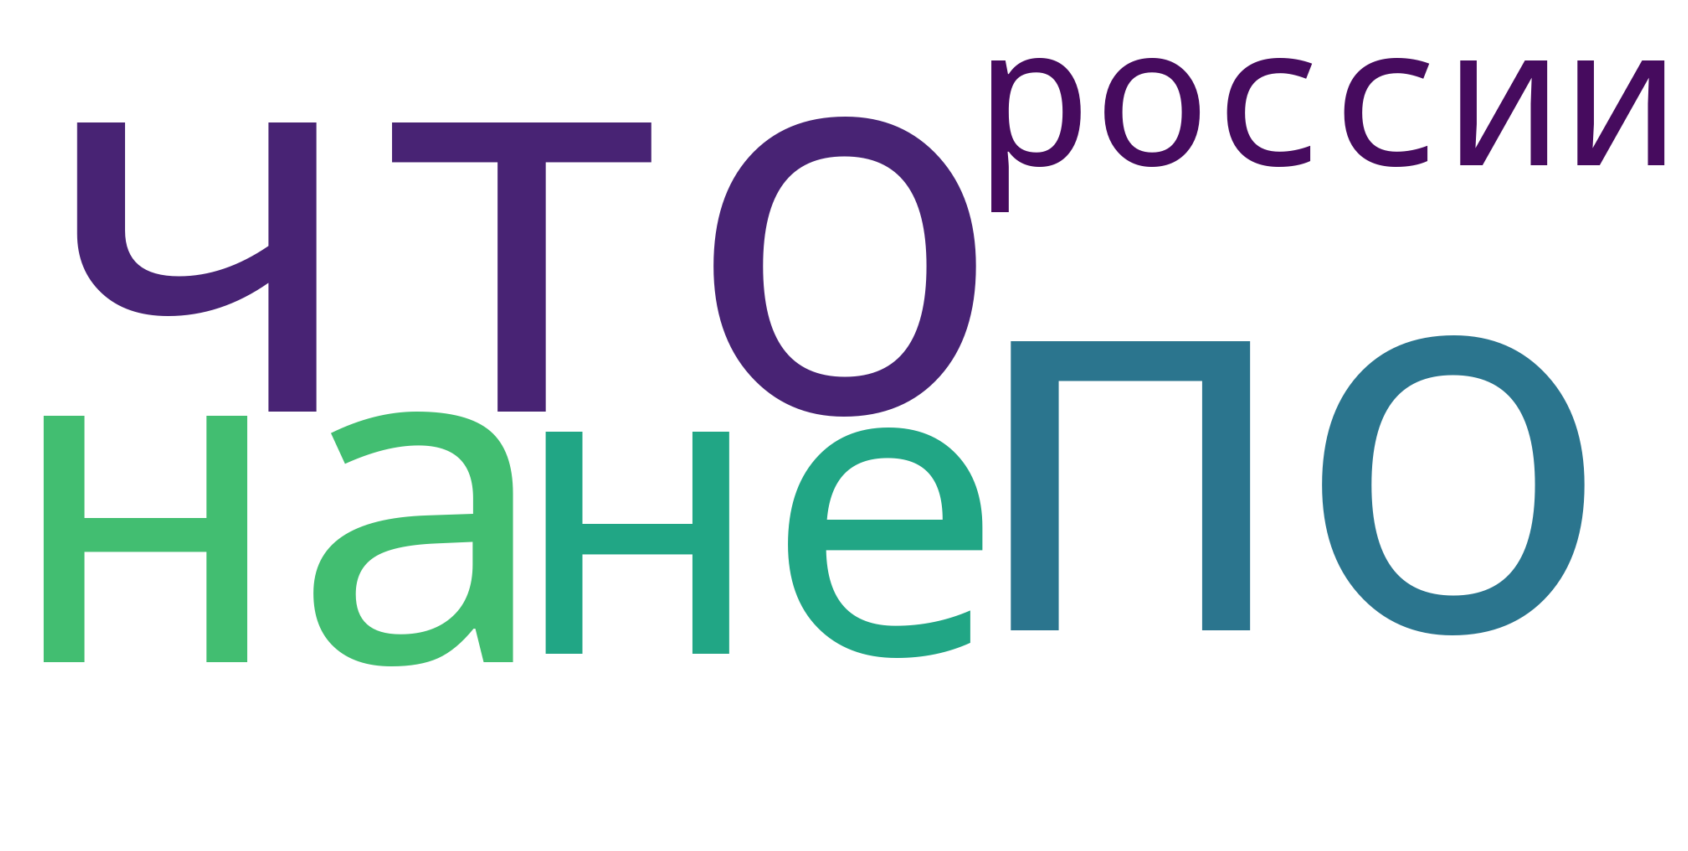

In [24]:
word_count_table.to_csv(f"top{n}_words.csv")
word_count_table['word']=word_count_table['word'].astype(str)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

text = ' '.join(word_count_table.word.values)
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, collocations=False, background_color="white").generate(text)
plt.figure(figsize=(30, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

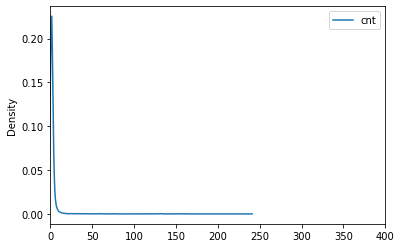

In [29]:
dff.plot(x='word', y='cnt', kind='kde', xlim=(0, 400))